# Importación de librerías

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import itertools
import matplotlib
from datetime import datetime 
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
sns.set()

# 1. Forecast de ventas de vino

### 1.1 Exploración de datos

In [2]:
data = pd.read_csv('/home/ignacio/github/labIC/lab1/AustralianWines.csv')

In [3]:
data.head()

,Month,Fortified,Red,Rose,sparkling,Sweet white,Dry white
0,Jan-80,2585,464,112,1686,85,1954
1,Feb-80,3368,675,118,1591,89,2302
2,Mar-80,3210,703,129,2304,109,3054
3,Apr-80,3111,887,99,1712,95,2414
4,May-80,3756,1139,116,1471,91,2226


In [4]:
data.dtypes

Month          object
Fortified       int64
Red             int64
Rose           object
sparkling       int64
Sweet white     int64
Dry white       int64
dtype: object

**Observamos que la columna Rose, no es de tipo entero**

In [5]:
data['Rose ']

0      112
1      118
2      129
3       99
4      116
      ... 
175      *
176     46
177     51
178     63
179     84
Name: Rose , Length: 180, dtype: object

**Se intentará encontrar las filas que contengan valores erróneos.**

In [6]:
notInt = {}
for i, value in enumerate(data['Rose ']):
    try:
        int(value)
    except:
        notInt[i] = value
print('Filas que no contienen valores enteros y su respectivo valor: ' , notInt)

Filas que no contienen valores enteros y su respectivo valor:  {174: '*', 175: '*'}


In [7]:
data[170:180]

,Month,Fortified,Red,Rose,sparkling,Sweet white,Dry white
170,Mar-94,1965,2201,42,1720,187,3754
171,Apr-94,2659,2455,48,1725,279,3708
172,May-94,2354,2204,44,1674,193,3210
173,Jun-94,2592,2660,45,1693,227,3517
174,Jul-94,2714,3670,*,2031,225,3905
175,Aug-94,2294,2665,*,1495,205,3670
176,Sep-94,2416,2639,46,2968,259,4221
177,Oct-94,2016,2226,51,3385,254,4404
178,Nov-94,2799,2586,63,3729,275,5086
179,Dec-94,2467,2684,84,5999,394,5725


**Por ahora solo reemplazaremos estos valores por cero (evaluar si se eliminan las filas, o reemplazamos por promedio)**

In [8]:
data['Rose '][174] = 0
data['Rose '][175] = 0
data['Rose '] = data['Rose '].astype(int)

<ipython-input-8-91e622e93bc5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Rose '][174] = 0
<ipython-input-8-91e622e93bc5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Rose '][175] = 0


In [9]:
arr = [datetime(1980 + j, i + 1, 1)  for j in range(15) for i in range(12)]
data['Date'] = pd.DataFrame(arr, dtype = 'datetime64[ns]')

In [10]:
data = data.set_index('Date')

In [11]:
data.index

DatetimeIndex(['1980-01-01', '1980-02-01', '1980-03-01', '1980-04-01',
               '1980-05-01', '1980-06-01', '1980-07-01', '1980-08-01',
               '1980-09-01', '1980-10-01',
               ...
               '1994-03-01', '1994-04-01', '1994-05-01', '1994-06-01',
               '1994-07-01', '1994-08-01', '1994-09-01', '1994-10-01',
               '1994-11-01', '1994-12-01'],
              dtype='datetime64[ns]', name='Date', length=180, freq=None)

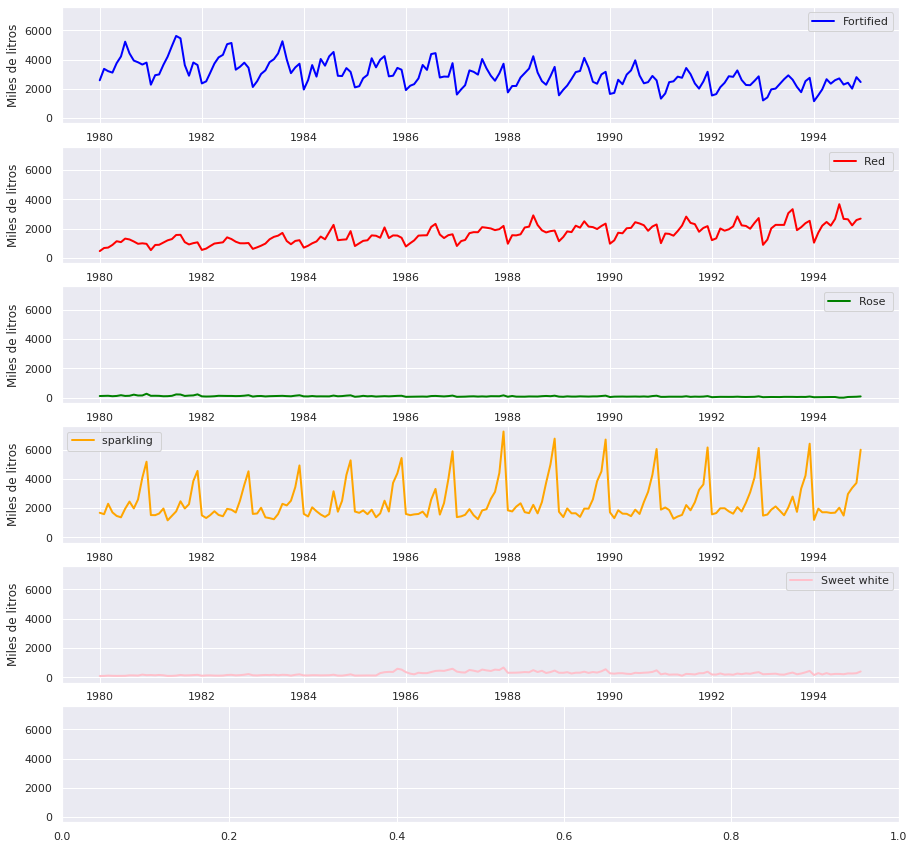

In [251]:
f, axes = plt.subplots(6, 1, sharey=True, figsize = (15,15))
colors = ['blue', 'red', 'green', 'orange', 'pink', 'purple']

for col, i, color in zip(data.columns[1:-1], range(6), colors):
    axes[i].plot(data[col], label = col, linewidth = 2, color = color)
    axes[i].legend()
    axes[i].set_xlabel('Año')
    axes[i].set_ylabel('Miles de litros')
plt.savefig('Series.pdf')

### 1.2 Seasonal descompose


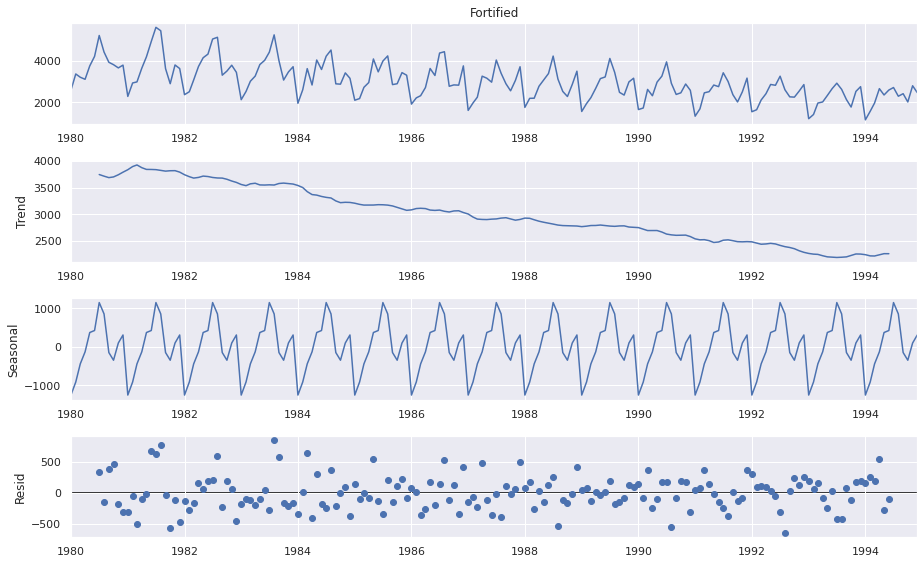

In [260]:
from pylab import rcParams
rcParams['figure.figsize'] = 13, 8
decomposition = sm.tsa.seasonal_decompose(data['Fortified'], model='additive', period = 12)
fig = decomposition.plot()
plt.show()
fig.savefig('seasonal_descompose.png')

### 1.3 Sarimax


In [14]:
train  = data[:126]
validacion = data[126:]

In [15]:

def sarimax_results(serie_name = 'Fortified', train_data = train, val_data = validacion):
    predictions = []
    confidence = []
    
    dates = val_data.index
    mod = sm.tsa.statespace.SARIMAX(train_data[serie_name],
                                    order=(1, 1, 1),
                                    seasonal_order=(1, 1, 1, 2),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    model_fit = mod.fit()
    train_pred = model_fit.predict(0,125)
    for date1, date2 in zip(dates[0::2], dates[1::2]):
        yhat = model_fit.get_prediction(start= date1, end = date2)
        confidence.append(yhat.conf_int())
        predictions.extend(yhat.predicted_mean)
        
        model_fit = model_fit.extend(val_data[date1:date2][serie_name])
        
    return pd.DataFrame(predictions, index = dates,columns = ['Prediccion validación']), model_fit, confidence, train_pred
 

In [16]:
def plot_results(pred, conf, train_predict, serie_name): 
    ax = pred.plot(figsize = (15,6))
    data[serie_name].plot(ax= ax, label = 'Real')

    upper= []
    lower = []
    idxs = []
    for value in conf:
        idx, y1, y2 = (value.index, value.iloc[:, 0], value.iloc[:, 1])
        upper.extend(y1)
        lower.extend(y2)
        idxs.extend(idx)

    ax.fill_between(x = idxs,
                    y1 = upper,
                    y2 = lower, color='k', alpha=.2)

    ax.set_xlabel('Fecha')
    ax.set_ylabel('Miles de litros')
    ax.set_title('Ventas de vino ' + serie_name.upper())
    train_predict.plot(ax = ax, label = 'Predicción entrenamiento')
    plt.legend()
    plt.show()
    fig = ax.get_figure()
    fig.savefig(serie_name + '.pdf')

In [17]:
def get_rmse(pred, serie_name):
    
    mse = ((np.asarray(pred).reshape(len(pred))- np.asarray(validacion[serie_name]))**2).mean()
    rmse = round(np.sqrt(mse),2)
    return round(mse,2), rmse

def get_rmse_train(train_predict, serie_name):
    mse = ((np.asarray(train_predict).reshape(len(train_predict))- np.asarray(train[serie_name]))**2).mean()
    
    rmse = round(np.sqrt(mse),2)
    return round(mse,2), rmse

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


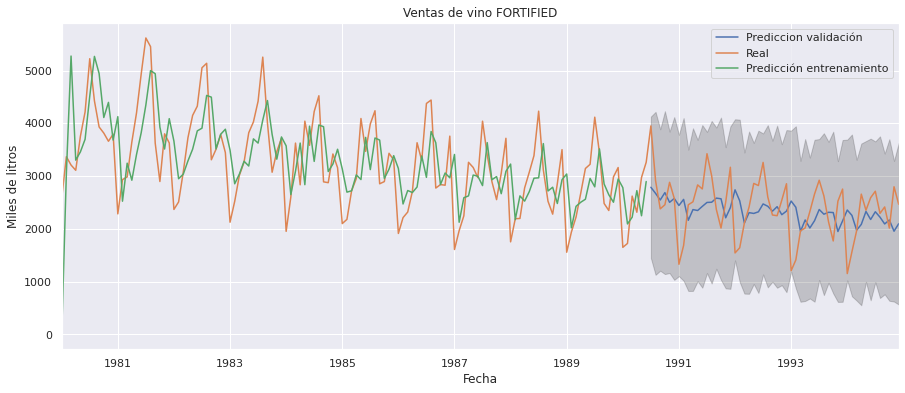

In [261]:
serie_name = 'Fortified' 
pred, model, conf, train_predict = sarimax_results(serie_name)
plot_results(pred, conf, train_predict, serie_name)

In [262]:
mse, rmse = get_rmse(pred, serie_name)
print('MSE: {}'. format(mse))
print('RMSE: {}'. format(rmse))

MSE: 336366.15
RMSE: 579.97


In [263]:
mse, rmse = get_rmse_train(train_predict, serie_name)
print('MSE: {}'. format(mse))
print('RMSE: {}'. format(rmse))

MSE: 584117.35
RMSE: 764.28


In [264]:
errores = np.abs((np.array(pred).reshape(len(pred))-np.array(validacion[serie_name])))
errores = pd.DataFrame(errores)

In [268]:
print(errores.quantile(0.1))

0    71.591246
Name: 0.1, dtype: float64


In [269]:
print(errores.quantile(0.9))

0    975.851657
Name: 0.9, dtype: float64


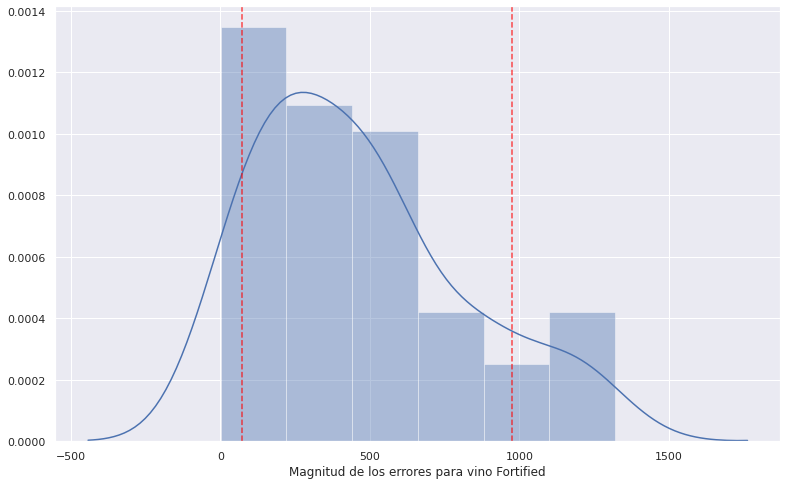

In [266]:
sns.distplot(errores, axlabel = 'Magnitud de los errores para vino '+ serie_name)
plt.axvline(errores.quantile(0.1)[0], color = 'red', linestyle = '--', alpha = 0.7)
plt.axvline(errores.quantile(0.9)[0], color = 'red', linestyle = '--', alpha = 0.7)
plt.savefig('hist'+ serie_name+'pdf')

## 1.4 MA con diferenciación

2.9 Usar la diferenciación para eliminar la tendencia y / o la estacionalidad de cada serie para
que luego podamos usar un promedio móvil para pronosticar las ventas futuras.

2.10 Escribir sobre las operaciones de diferenciación que aplicó a cada una de las seis
series, explicando por qué eligió esas operaciones. Incluir gráficos puede ayudar a respaldar
sus argumentos.

2.11 Predicción de ventas de vinos utilizando un MA: Use un promedio móvil con un
ancho de ventana de 12 (MA (12)) para pronosticar las ventas con doble diferencia de las
ventas de vino fortificado en febrero de 1995.

2.12 Finalmente, ajuste el pronóstico "sin diferenciar" dos veces, para incluir de nuevo la
tendencia y la estacionalidad. Reportar su pronóstico final para las ventas de vinos
fortificados en febrero de 1995 utilizando este método. Discuta cualquier desafío o pregunta
que haya encontrado

In [270]:
serie = 'Fortified'

def diferenciacion(serie):
    dif = train[serie] - train[serie].shift()    
    dif2 = dif.fillna(0) - dif.fillna(0).shift()
    dif_val = validacion[serie] - validacion[serie].shift()    
    dif2_val = dif_val.fillna(0) - dif_val.fillna(0).shift()
    
    
    return dif2, dif2_val

In [271]:
from statsmodels.tsa.arima.model import ARIMA
def ma_results(serie_name = 'Fortified', dif = True):
    predictions = []
    confidence = []
    if dif:
        train_data, val_data = diferenciacion(serie)
    else:
        train_data, val_data = train[serie], validacion[serie]
    dates = val_data.index
    mod = ARIMA(train_data, order=(0, 0, 12))
    
    model_fit = mod.fit()
    train_pred = model_fit.predict(0,125)
    for date1, date2 in zip(dates[0::2], dates[1::2]):
        yhat = model_fit.get_prediction(start= date1, end = date2)
        confidence.append(yhat.conf_int())
        predictions.extend(yhat.predicted_mean)
        
        model_fit = model_fit.extend(val_data[date1:date2])
        
    return pd.DataFrame(predictions, index = dates,columns = ['Prediccion validación']), model_fit, confidence, train_pred
 

In [272]:
pred, modl, confidence, pred_train =  ma_results(serie)
dif2_train, dif2_val = diferenciacion(serie)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimizati

In [273]:
date1 = pd.datetime(1995, 1, 1) #enero
date2 = pd.datetime(1995, 2, 1) #febrero

<ipython-input-273-0347d65d625b>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  date1 = pd.datetime(1995, 1, 1)
<ipython-input-273-0347d65d625b>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  date2 = pd.datetime(1995, 2, 1)


In [165]:
#Predicciones para enero y febrero 1995
predictions = modl.get_prediction(start= date1, end = date2).predicted_mean

#Recuperamos los valores haciendo "des-diferenciacion"
enero = predictions[0] - validacion[serie][-2]+ 2*validacion[serie][-1]
febrero = predictions[1] - validacion[serie][-1] + 2*enero

y_hat_dif2 = pd.DataFrame([validacion[serie][-1],enero, febrero],columns = ['Predicción con diferenciación'], index = validacion.index[-1:].append(predictions.index))

### Sin diferenciacion

In [167]:
pred, modl, confidence, pred_train =  ma_results(serie, dif = False)


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [168]:
[enero, febrero] = modl.get_prediction(start= date1, end = date2).predicted_mean
y_hat = pd.DataFrame([validacion[serie][-1],enero, febrero],columns = ['Predicción sin diferenciación'], index = validacion.index[-1:].append(predictions.index))

<ipython-input-184-9b1917e58521>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ax.set_xlim((pd.datetime(1980,1,1), pd.datetime(1995,5,1)))


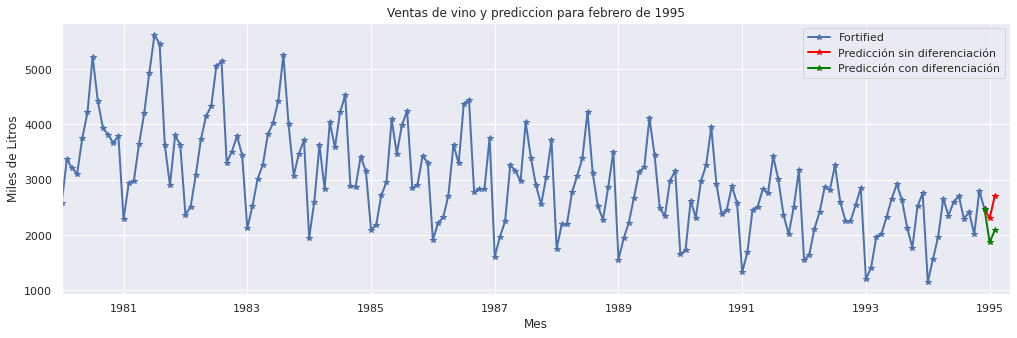

In [184]:
ax = data[serie].plot(figsize = (17,5), marker = '*', linewidth =2)
y_hat.plot(ax = ax, marker = '*', linewidth = 2, color = 'red')
y_hat_dif2.plot(ax = ax, marker = '*', linewidth = 2, color = 'green')

ax.set_xlim((pd.datetime(1980,1,1), pd.datetime(1995,5,1)))
ax.set_xlabel('Mes')
ax.set_ylabel('Miles de Litros')
ax.set_title('Ventas de vino y prediccion para febrero de 1995')
plt.legend()
fig = ax.get_figure()
fig.savefig(serie + '_dif.pdf')


# 2. Diseño de Experimentos (DoE) para mejorar los costos de producción de una empresa de manufactura que utiliza fibra sintética

### 2.1 Datos 

### 2.2 ANOVA

### 2.3 [OPCIONAL] Prueba de comparaciones múltiples